# Sheet music analyzer

## I Setting environments and importing necessary packages

In [15]:
from music21 import *
import pandas as pd
us = environment.UserSettings()
us['musicxmlPath'] = 'C:\\Program Files\\MuseScore 3\\bin\\MuseScore3.exe'
us['musescoreDirectPNGPath'] = 'C:\\Program Files\\MuseScore 3\\bin\\MuseScore3.exe'
us['musicxmlPath']

WindowsPath('C:/Program Files/MuseScore 3/bin/MuseScore3.exe')

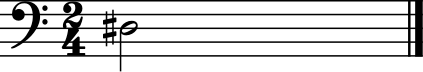

In [16]:
n = note.Note("D#3")
n.duration.type = 'half'
n.show()

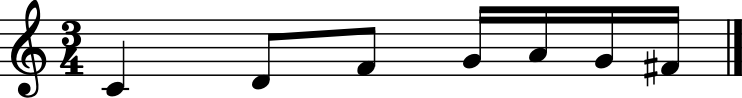

In [17]:
littleMelody = converter.parse("tinynotation: 3/4 c4 d8 f g16 a g f#")
littleMelody.show()

In [18]:
littleMelody.show('midi')

### Precious algorithms (maybe to be used)

In [19]:
#Leiab kõik taktid ja takti sisu ning paneb need sõnastikku, sõnastikud lähevad listi
def get_measure_info(part, partList):
    measures = [] #List, kuhu lähevad measure dictid:
    chords = []
    rests = []
    notes = []
    allInfo = []
    melNotes = []
    notesDur = 0
    restsDur = 0
    for e in part.getElementsByClass('Measure'):
        newMeasure = {}        
        newMeasure[e.number] = list(e.notesAndRests.elements) #EVERYTHING IN one place
        measureInt =[]
        if e.hasVoices():
            for voice in e.getElementsByClass('Voice'):
                for v in voice.elements:
                    newMeasure[e.number].append(v)
        for elem in newMeasure[e.number]:
            if elem.isNote:
                notes.append(elem.nameWithOctave)
                notesDur+=elem.duration.quarterLength
                allInfo.append(elem)
                measureInt.append(elem)
                melNotes.append(elem)
            elif elem.isChord and '<music21.harmony.ChordSymbol' not in str(elem):
                chords.append(elem.pitchedCommonName)
                notesDur+=elem.duration.quarterLength
                measureInt.append(elem.notes[-1])
                allInfo.append(elem.notes[-1])
                melNotes.append(elem.notes[-1])
                for c in elem.notes:
                    notes.append(c.nameWithOctave)
            elif elem.isRest:
                restsDur+=elem.duration.quarterLength
        newMeasure[e.number].append(measureInt) 
        measures.append(newMeasure)
    rests.append(notesDur)
    rests.append(restsDur)
    partList['melodynotes'] = melNotes
    partList['notes'] = notes
    partList['chords'] = chords
    partList['rests'] = rests
    partList['intervals'] = find_intervals(allInfo)
    
    return measures

In [61]:
#Taandab kõik intervallid 0-12 pooltooni vahemikku
def check_semitones1(st_inter, intervals):
    if 24 > st_inter > 12:
        st_inter = st_inter-12
        intervals.append(st_inter)
    elif 36 > st_inter > 24:
        st_inter = st_inter-24
        intervals.append(st_inter)
    elif 48 > st_inter > 36:
        st_inter = st_inter-36
        intervals.append(st_inter)
    elif -24 < st_inter < -12:
        st_inter = st_inter+12
        intervals.append(st_inter)
    elif -36 < st_inter < -24:
        st_inter = st_inter+24
        intervals.append(st_inter)
    elif -48 < st_inter < -36:
        st_inter = st_inter+36
        intervals.append(st_inter)
    else:
        intervals.append(st_inter)

#Taandab kõik intervallid 0-12 pooltooni vahemikku
def check_semitones(st_inter, intervals):
    if st_inter > 12:
        st_inter = st_inter % 12  
    elif st_inter < -12:
        st_inter = st_inter % -12
    intervals.append(st_inter)
    
        
#Tuvastab nootide vahelised intervallid  
def find_intervals(allInfo):
    intervals= []
    i=1 #Alustan 2. noodist, sest pean alati kontrollima, kas eelmine noot on noot või mitte.
    while i != len(allInfo) and len(allInfo) != 0 and len(allInfo) != 1:
        if allInfo[i-1].isNote and allInfo[i].isNote:
            inter = interval.Interval(noteStart=allInfo[i-1], noteEnd=allInfo[i]).semitones
            check_semitones(inter,intervals)
            
        i+=1
    return intervals

#Saame instrumentide nimed kätte partiidest
def get_instruments(note):
    lst=[]
    for i in range (len(note)):
        if 'partName' in note[i]:
            lst.append(note[i].get('partName'))
    return lst

#Saame tõenäoliseima noodi helistiku
def get_key(note):
    lst=[]
    for i in range (len(note)):
        if 'key' in note[i]:
            lst.append(note[i].get('key'))
    if lst == []:
        return "Ei suutnud helistikku määrata."
    else:
        return str(max(set(lst), key = lst.count))
    
#Saame noodis esinevate taktide arvu
def get_bars_count(note):
    return len(note[1].get('measures'))

#Saame kätte enimkasutatud nootide, intervallide jne info
def get_elements_info(note, name):
    intervalDict = {0:"P0", 1:"v2", 2:"S2",
                    3:"v3", 4:"S3", 5:"P4", 6:"Tritoon",
                    7:"P5", 8:"v6", 9:"S6", 10:"v7",
                    11: "S7", 12:"P8"}
    count= 0
    mostUsed = "Puudub"
    lst = []
    for i in range(0,len(note)):
        elements = note[i].get(name)
        s = len(elements)
        count+=s
        lst+=elements
    
    if lst != []:
        mostUsed = max(set(lst), key=lst.count)
    if name=="intervals":
        mostUsed = intervalDict.get(mostUsed)
    
    return (count, mostUsed)

#Saame teada noodis olevate pauside protsentuaalse koguse
def get_rests_info(note, name):
    notesDur =0
    restsDur =0
    wholeDur =0
    for elem in note:
        if name in elem:
            elements = elem.get(name)
            notesDur+=elements[0]
            restsDur+=elements[1]
    wholeDur+= notesDur + restsDur
    percent = (restsDur*100)/wholeDur
    return str(round(percent,1))

#Saame kätte noodi tempo
def get_tempo(note):
    return note[1].get('bpm')

In [62]:
# Analyze gives: 
# list[0] - sheet name
# list [1] - info of the sheet and partList 1 (esimene rida)- CHECK the ALGORITHM
# list [2] - info of the sheet and partList 2 (teine rida) - ainult meloodia noot, kui chordi ära ei arva.
# list [3] - kõik noodid üldse kokku
# list [4] - kõik intervallid üldse kokku

## New algorithms 

Offset näitab mitmenda täislöögi indeksist takt algab (index 0, 1, 2....) Kui offset on 3, siis takt algab kogu noodistuse mõistes 3. löögist

In [63]:
#Leiab kõik taktid ja takti sisu ning paneb need sõnastikku, sõnastikud lähevad listi
def get_measure_info(part, partList):
    measures = [] #List, kuhu lähevad measure dictid:
    chords = []
    rests = []
    notes = []
    allInfo = []
    melNotes = []
    notesDur = 0
    restsDur = 0
    for e in part.getElementsByClass('Measure'):
        newMeasure = {}        
        newMeasure[e.number] = list(e.notesAndRests.elements)
        print(newMeasure)
        measureInt =[]
        if e.hasVoices():
            for voice in e.getElementsByClass('Voice'):
                for v in voice.elements:
                    newMeasure[e.number].append(v)
        for elem in newMeasure[e.number]:
            if elem.isNote:
                notes.append(elem.nameWithOctave)
                notesDur+=elem.duration.quarterLength
                allInfo.append(elem)
                measureInt.append(elem)
                melNotes.append(elem)
            elif elem.isChord and '<music21.harmony.ChordSymbol' not in str(elem):
                chords.append(elem.pitchedCommonName)
                notesDur+=elem.duration.quarterLength
                
                #Takes the first note of the chords
                measureInt.append(elem.notes[-1])
                allInfo.append(elem.notes[-1])
                melNotes.append(elem.notes[-1])
                for c in elem.notes:
                    notes.append(c.nameWithOctave)
            elif elem.isRest:
                restsDur+=elem.duration.quarterLength
        newMeasure[e.number].append(measureInt) 
        measures.append(newMeasure)
    rests.append(notesDur)
    rests.append(restsDur)
    partList['melodynotes'] = melNotes
    partList['notes'] = notes
    partList['chords'] = chords
    partList['rests'] = rests
    partList['intervals'] = find_intervals(allInfo)
    
    return measures

In [64]:
def get_measure_and_notes(part):
    measures = []
    detailed_seq = [] #Whole note part sequence without meassure markings
    for e in part.getElementsByClass('Measure'):
        newMeasure = {}        
        newMeasure[e.number] = list(e.notesAndRests.elements)
        
        for elem in newMeasure[e.number]:
            off_s = elem.offset
            if elem.isNote:
                detailed_seq.append((e.number, str(elem.pitch.midi), elem.duration.quarterLength, off_s))
                #detailed_seq.append(str(elem.nameWithOctave) + '_'+ str(elem.duration.quarterLength))
                
            elif elem.isChord and '<music21.harmony.ChordSymbol' not in str(elem):
                notes = []
                
                for c in elem.notes:
                
                    notes.append((e.number, str(c.pitch.midi), c.duration.quarterLength, off_s))
                detailed_seq.append(notes)
            elif elem.isRest:
                detailed_seq.append((e.number, str(elem.name) + '_'+ str(elem.duration.quarterLength)))
        
        measures.append(newMeasure)
    #print(detailed_seq)
    return detailed_seq


* Kuidas märkida muutuva taktimõõdu või muutuva tempo korral? Kõik taktimõõdud üle partii märgitakse üles.

* Kuidas märkida parima tulemusega helistik? - Helistikke leitakse kahe algoritmiga, Krumhansl ja AardenEssen - kui tulemused on erinevad, siis pannakse mõlemad tabelisse sisse, kontroll sharpside osas ja teha n-ö 1. valik ja 2. valik

* Tempo määramine - sõnastiku järgi kui on sõna, numbri järgi kui on number Checki mitmeid numbereid sõna vastu (sõnastik tempode märkidest



MIDI = 64 -> MIDI TO NOTE -> note.Note(elem.pitch.midi).nameWithOctave (E4) - note type

In [65]:
def gather_part_info(note, noteName, note_id):
    allNote = [] #Every part of the instrument is collected here
    part_count = 1
    for el in note.elements: #Iga part eraldi el = PartStaff
        #Basic info
        partList = {}
        partList['note_id'] = note_id
        partList['note_part_id'] = str(note_id) + "_" + str(part_count)
        partList['sheet_name'] = noteName
        partList['partName'] = el.partName 
        partList['sharps'] = el[1].keySignature.sharps #1. taktist saab helistiku märgid kätte.
        partList['bpm'] = "None"
        
        part_count +=1
        #Find the key
        try:
            if el.analyze('Krumhansl') == el.analyze('AardenEssen'):
                partList['key'] = el.analyze('Krumhansl').name  #MusicXML enda tuvastusalgoritm (ei ole alati täpne)
            else:
                partList['key'] = str(el.analyze('Krumhansl').name) + "  /  " +  str(el.analyze('AardenEssen')) #TODO: Check against dictionary
        except:
            partList['key'] = "None"
            
        #Find time signature
        time_signatures = []
        for i in (el['TimeSignature']):
            time_signatures.append(str(i.numerator) + '/' + str(i.denominator))
        if len(set(time_signatures)) == 0:
            partList['time_signature'] = "None"
        elif len(set(time_signatures)) == 1:
            partList['time_signature'] = time_signatures[0]
        else:
            partList['time_signature'] = set(time_signatures)
        
        #Find the Metronome
        metronome = []
        for i in el['MetronomeMark']: #TODO: Check against dictionary
            metronome.append(str(i.number))
        if len(set(metronome)) == 0:
            partList['bpm (quarter note)'] = "None" #MuseScore gives a default of 120.
        elif len(set(metronome)) == 1:
            partList['bpm (quarter note)'] = metronome[0]
        else:
            partList['bpm (quarter note)'] = set(metronome)
            
        #Find the clef
        partList['clef'] = el[1].clef.name
        partList['measures'] = get_measure_and_notes(el)
        #print(partList['measures'])
        allNote.append(partList)
    return allNote

Sheets may have textboxes before the partstaffs.

* sheet[0][0] - metadata

* sheet[1] -> 1.partStaff
* sheet[1][1] -> 1. partStaff 1. measure
* sheet[1][1][1] -> 1. partStaff 1. measure 'SystemLayout' 
* sheet[1][1][1] -> 1. partStaff 1. measure 'Trebleclef' 
* sheet[1][1][2] -> 1. partStaff 1. measure 'Keysignature'
* sheet[1][1][3] -> 1. partStaff 1. measure 'Timesignature'
* sheet[1][1][4] -> 1. partStaff 1. measure First Note / Chord
    - If chord then
      *   sheet[1][1][4][0] -> 1. partStaff 1. measure First Note, lower note
      *   sheet[1][1][4][1] -> 1. partStaff 1. measure First Note, upper note

* len(c.flatten().getElementsByClass(chord.Chord)) - get all the chord elements of entire sheet
* len(c.flatten().getElementsByClass(note.Note)) - get all the note elements of entire sheet (no chord notes)

### Change key of the note (or part)

In [169]:
#Change all keys to either a-minor or C-major
def key_change_to_base(note): 
    
    k = note.analyze('key')
    
    if 'major' in str(k):
        i = interval.Interval(k.tonic, pitch.Pitch('c'))
    else:
        i = interval.Interval(k.tonic, pitch.Pitch('a'))
    sNew = note.transpose(i)
    kNew = sNew.analyze('key')
    
    return sNew


## Playback function

[(1, '57', 0.5, 0.0), (1, '64', 0.5, 0.5), (1, '59', 0.5, 1.0), (1, '52', 0.5, 1.5), (1, '60', 0.5, 2.0), (1, '64', 0.5, 2.5), (1, '64', 0.5, 3.0), (1, '52', 0.5, 3.5)]


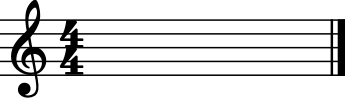

In [71]:
#print(note_info[0]['measures'])

len(note_info[0]['measures'])
matched_seq = note_info[0]['measures'][0:8]
print(matched_seq)



def get_playback_info(note_info, matched_seq):
    playback = {}
    key = note_info[0]['key'][0]
    time= note_info[0]['time_signature']
    
    notes = ''
    for elem in matched_seq:
        note = elem[0]
        octave =elem[1]
        duration = elem[2]
    
        if octave == 4:
            note = note.lower()
        if duration == 0.5:
            duration = 8
    
        notes = notes + str(note) + str(duration) + ' '
    tinynote = str(time) + ' ' + 'k'+(str(key.lower()) + ' ' + notes)
    return tinynote



tiny = get_playback_info(note_info, matched_seq)

class KeyToken(tinyNotation.Token):
    def parse(self, parent):
        keyName = self.token
        return key.Key(keyName)
tnc = tinyNotation.Converter()
print(tnc)
keyMapping = (r'k(.*)', KeyToken)
tnc.tokenMap.append(keyMapping)
tnc.load(tiny)

tnc.parse()
s = tnc.stream
s.append(tempo.MetronomeMark(150))
s.show()
s.show('midi')


In [72]:
s.show('midi') #default playback tempo is 120, always TODO: How to change?

# Building the dataframe for sheet note information

### measures - [a,b,c,d]

* a - measure nr.
* b - MIDI mark of the note (can get note pitch and note octave from it)
* c - duration of the note
* d - float = offbeat, integer = on-beat.

In [73]:
# Import pandas library
import pandas as pd

df = pd.DataFrame(note_info)
df

,note_id,note_part_id,sheet_name,partName,sharps,bpm,key,time_signature,bpm (quarter note),clef,measures
0,2,2_1,bond,Piano,0,None,A minor,4/4,72.0,treble,"[(1, 57, 0.5, 0.0), (1, 64, 0.5, 0.5), (1, 59,..."
1,2,2_2,bond,Piano,0,None,A minor,4/4,72.0,bass,"[[(1, 33, 3.0, 0.0), (1, 45, 3.0, 0.0)], (1, 7..."


### Removing off-beat of the note sheet.

Every note/chord that doesn't land in the beat is removed. 

In [237]:
#REMOVE RESTS BEFORE REMOVING OFFBEAT
def remove_rests(lst):
    for elem in lst:
        if 'rest_' in elem[1]:
            lst.remove(elem)
    return lst

def remove_offbeat(lst):
    lst_new = remove_rests(lst)
    
    new_lst = []
    for elem in lst_new:
        
        if isinstance(elem, list):
            if elem[0][-1].is_integer():
                new_lst.append(elem)
        else:
            if type(elem[-1]) == str:
                lst_new.remove(elem)
            else:
                if elem[-1].is_integer():
                    new_lst.append(elem)

    return new_lst

In [147]:
lst = []

def construct_strings(n, if_rest, if_chords, m, o, offset):
    lst = []
    if offset == False: 
        n = remove_offbeat(n)
    for i in n:
        if if_rest == False:
            if 'rest' in i[1]:
                continue #skipping rests
        if isinstance(i, list):
            if if_chords == False: #Takes the first note of the chord into account
                elem = i[0][m:o]
                s = ' '.join(map(str,elem))
                lst.append(s)
            else: #Takes the whole chord into account
                cover_lst = []
                for elem in i:

                    elem = elem[m:3]
                    cover_lst.append(elem)
                s = ' '.join(map(str,cover_lst))
                lst.append(s)
        else:
            if 'rest' in i[1]:
                i = i[m:2]
                s = ' '.join(map(str,i))
                lst.append(s)
            else:
                i = i[m:o]
                s = ' '.join(map(str,i))
                lst.append(s)
    return lst
#For [3] and [4]
# 0 - if measure nr IS taken into account
# 1 - if measure nr is NOT taken into account
# 2 - if note duration is NOT taken into account
# 3 - if note duration IS taken into account


#a = construct_strings(df['measures'][0], False, True, 0, 3, True) 
#b = construct_strings(df['measures'][1], False, True, 0, 3, True)



## N-GRAM

#### Ukkonen measure?

In [125]:
def generate_ngrams(s, n):
    # Use the zip function to help us generate n-grams
    # Concatentate the tokens into ngrams and return
    ngrams = zip(*[s[i:] for i in range(n)])
    return [ngram for ngram in ngrams]

## Jaccard similarity
The Jaccard Index, also known as the Jaccard similarity coefficient, is a statistic used in understanding the similarities between sample sets. The measurement emphasizes similarity between finite sample sets, and is formally defined as the size of the intersection divided by the size of the union of the sample sets. 

In [126]:
# Get Tuple algorithms 
import re
import math
import numpy as np
from itertools import chain
from collections import Counter
import nltk
from nltk.util import ngrams # This is the ngram magic.

def jaccard_distance(a, b):
    """Calculate the jaccard distance between sets A and B"""
    intersection = len(list(set(a).intersection(b)))
    union = (len(set(a)) + len(set(b))) - intersection
    return float(intersection) / union


In [127]:
print("Jaccard: {}".format(jaccard_distance(a_gram,b_gram))

SyntaxError: unexpected EOF while parsing (Temp/ipykernel_5632/2132400879.py, line 1)

## Jaro similarity
Jaro Similarity is the measure of similarity between two strings. The value of Jaro distance ranges from 0 to 1. where 1 means the strings are equal and 0 means no similarity between the two strings. 

In [ ]:
# Python3 implementation of above approach
from math import floor, ceil
 
# Function to calculate the
# Jaro Similarity of two s
def jaro_distance(s1, s2):
     
    # If the s are equal
    if (s1 == s2):
        return 1.0
 
    # Length of two s
    len1 = len(s1)
    len2 = len(s2)
 
    # Maximum distance upto which matching
    # is allowed
    max_dist = floor(max(len1, len2) / 2) - 1
 
    # Count of matches
    match = 0
 
    # Hash for matches
    hash_s1 = [0] * len(s1)
    hash_s2 = [0] * len(s2)
 
    # Traverse through the first
    for i in range(len1):
 
        # Check if there is any matches
        for j in range(max(0, i - max_dist),
                       min(len2, i + max_dist + 1)):
             
            # If there is a match
            if (s1[i] == s2[j] and hash_s2[j] == 0):
                hash_s1[i] = 1
                hash_s2[j] = 1
                match += 1
                break
 
    # If there is no match
    if (match == 0):
        return 0.0
 
    # Number of transpositions
    t = 0
    point = 0
 
    # Count number of occurrences
    # where two characters match but
    # there is a third matched character
    # in between the indices
    for i in range(len1):
        if (hash_s1[i]):
 
            # Find the next matched character
            # in second
            while (hash_s2[point] == 0):
                point += 1
 
            if (s1[i] != s2[point]):
                t += 1
            point += 1
    t = t//2
 
    # Return the Jaro Similarity
    return (match/ len1 + match / len2 +
            (match - t) / match)/ 3.0
 
 
# Prjaro Similarity of two s
print(round(jaro_distance(a_gram, b_gram),6))
 
# This code is contributed by mohit kumar 29

In [77]:
from difflib import SequenceMatcher

def match_seq(list1,list2):
    output=[]
    s = SequenceMatcher(None, list1, list2)
    blocks=s.get_matching_blocks()
    for bl in blocks:
        for bi in range(bl.size):
            cur_a=bl.a+bi
            cur_b=bl.b+bi
            output.append((cur_a,cur_b))
    return output


# Bach's corpus (last index is 412)
### (.krn file is HUMDRUM tool KERN file - these files are not included)

In [26]:
from music21 import corpus
from pathlib import Path  

paths = corpus.getComposer('bach')

#del df #delete previos test df

c3 = converter.parse(r'C:\Users\Lleis\Documents\SCHOOL\digimagister\digital_sheet_music_analysis\musicxml notes\bond3.musicxml')
partStream2 = c3.parts.stream()
note_info2= gather_part_info(partStream2, 'bond', 2)
df = pd.DataFrame(note_info2)

list_of_music = []
paths = corpus.getComposer('bach')
for i in paths:
    list_of_music.append(i.name)

test = list_of_music[0:413]

for note in test:
    if '.mxl' in note:
        s = corpus.parse('bach/' + note)

        partStream2 = s.parts.stream()
        idx = df['note_id'].iloc[-1]

        note_info2= gather_part_info(partStream2, note, idx+1)
        df_new = pd.DataFrame(note_info2)

        df = df.append(df_new, ignore_index = True)


In [27]:
df

,note_id,note_part_id,sheet_name,partName,sharps,bpm,key,time_signature,bpm (quarter note),clef,measures
0,2,2_1,bond,Piano,2,None,B minor,4/4,72.0,treble,"[(1, 59, 0.5, 0.0), (1, 66, 0.5, 0.5), (1, 61,..."
1,2,2_2,bond,Piano,2,None,B minor,4/4,72.0,bass,"[[(1, 35, 3.0, 0.0), (1, 47, 3.0, 0.0)], (1, 7..."
2,3,3_1,bwv1.6.mxl,Horn 2,-1,None,F major,4/4,None,treble,"[(0, 65, 1.0, 0.0), (1, 67, 0.5, 0.0), (1, 60,..."
3,3,3_2,bwv1.6.mxl,Soprano,-1,None,F major,4/4,None,treble,"[(0, 65, 1.0, 0.0), (1, 72, 1.0, 0.0), (1, 69,..."
4,3,3_3,bwv1.6.mxl,Alto,-1,None,F major,4/4,None,treble,"[(0, 60, 1.0, 0.0), (1, 60, 1.0, 0.0), (1, 60,..."
...,...,...,...,...,...,...,...,...,...,...,...
1752,409,409_7,bwv97.9.mxl,Bass,-2,None,B- major,4/4,None,bass,"[(0, 46, 1.0, 0.0), (1, 58, 1.0, 0.0), (1, 57,..."
1753,410,410_1,bwv99.6.mxl,Soprano,1,None,D major / G major,4/4,None,treble,"[(0, 62, 1.0, 0.0), (1, 67, 1.0, 0.0), (1, 69,..."
1754,410,410_2,bwv99.6.mxl,Alto,1,None,G major / D major,4/4,None,treble,"[(0, 59, 0.5, 0.0), (0, 60, 0.5, 0.5), (1, 62,..."
1755,410,410_3,bwv99.6.mxl,Tenor,1,None,B minor / G major,4/4,None,bass,"[(0, 55, 0.5, 0.0), (0, 57, 0.5, 0.5), (1, 59,..."


In [170]:
c3 = converter.parse(r'C:\Users\Lleis\Documents\SCHOOL\digimagister\digital_sheet_music_analysis\musicxml notes\bond3.musicxml')
partStream2 = c3.parts.stream()
note_info2= gather_part_info(partStream2, 'bond', 2)
df_base = pd.DataFrame(note_info2)


list_of_music = []
paths = corpus.getComposer('bach')
for i in paths:
    list_of_music.append(i.name)

test = list_of_music[0:413] #it is the last index of Bach corpus

for note in test:
    if '.mxl' in note:
        s = corpus.parse('bach/' + note)
        sNew = key_change_to_base(s)
        partStream2 = sNew.parts.stream()
        idx = df_base['note_id'].iloc[-1]

        note_info2= gather_part_info(partStream2, note, idx+1)
        df_new = pd.DataFrame(note_info2)

        df_base = df_base.append(df_new, ignore_index = True)

In [171]:
df_base

,note_id,note_part_id,sheet_name,partName,sharps,bpm,key,time_signature,bpm (quarter note),clef,measures
0,2,2_1,bond,Piano,2,None,B minor,4/4,72.0,treble,"[(1, 59, 0.5, 0.0), (1, 66, 0.5, 0.5), (1, 61,..."
1,2,2_2,bond,Piano,2,None,B minor,4/4,72.0,bass,"[[(1, 35, 3.0, 0.0), (1, 47, 3.0, 0.0)], (1, 7..."
2,3,3_1,bwv1.6.mxl,Horn 2,0,None,C major,4/4,None,treble,"[(0, 60, 1.0, 0.0), (1, 62, 0.5, 0.0), (1, 55,..."
3,3,3_2,bwv1.6.mxl,Soprano,0,None,C major,4/4,None,treble,"[(0, 60, 1.0, 0.0), (1, 67, 1.0, 0.0), (1, 64,..."
4,3,3_3,bwv1.6.mxl,Alto,0,None,C major,4/4,None,treble,"[(0, 55, 1.0, 0.0), (1, 55, 1.0, 0.0), (1, 55,..."
...,...,...,...,...,...,...,...,...,...,...,...
1752,409,409_7,bwv97.9.mxl,Bass,0,None,C major,4/4,None,bass,"[(0, 36, 1.0, 0.0), (1, 48, 1.0, 0.0), (1, 47,..."
1753,410,410_1,bwv99.6.mxl,Soprano,0,None,G major / C major,4/4,None,treble,"[(0, 55, 1.0, 0.0), (1, 60, 1.0, 0.0), (1, 62,..."
1754,410,410_2,bwv99.6.mxl,Alto,0,None,C major / G major,4/4,None,treble,"[(0, 52, 0.5, 0.0), (0, 53, 0.5, 0.5), (1, 55,..."
1755,410,410_3,bwv99.6.mxl,Tenor,0,None,E minor / C major,4/4,None,bass,"[(0, 48, 0.5, 0.0), (0, 50, 0.5, 0.5), (1, 52,..."


### Longest Common Subsequence

The longest common subsequence (LCS) problem consists in finding the longest subsequence common to two (or more) sequences. It differs from problems of finding common substrings: unlike substrings, subsequences are not required to occupy consecutive positions within the original sequences.

It is used by the diff utility, by Git for reconciling multiple changes, etc.

The LCS distance between strings X (of length n) and Y (of length m) is n + m - 2 |LCS(X, Y)| min = 0 max = n + m

LCS distance is equivalent to Levenshtein distance when only insertion and deletion is allowed (no substitution), or when the cost of the substitution is the double of the cost of an insertion or deletion.

This class implements the dynamic programming approach, which has a space requirement O(m.n), and computation cost O(m.n).

In "Length of Maximal Common Subsequences", K.S. Larsen proposed an algorithm that computes the length of LCS in time O(log(m).log(n)). But the algorithm has a memory requirement O(m.n²) and was thus not implemented here.

**The lower the number the bigger the subsequence**

In [182]:
n1 = df_base['measures'][100]
n2 = df_base['measures'][100]

In [79]:
from similarity.longest_common_subsequence import LongestCommonSubsequence

lcs = LongestCommonSubsequence()
print(lcs.distance(a,b))

1221.0


In [82]:
from similarity.ngram import NGram

twogram = NGram(6)
print(twogram.distance(a, b))

0.9495555555555554


## Analysis of Bach corpus

In [174]:
#[0] - df measures
#[1] - if_rest -> use the rests
#[2] - if_chords,
#[3] - m -> can be 0 or 1
#[4] - o -> can be 2 or 3
#[5] - offset -> remove offset (also removes rests)


#For [3] and [4]
# 0 - if measure nr IS taken into account
# 1 - if measure nr is NOT taken into account
# 2 - if note duration is NOT taken into account
# 3 - if note duration IS taken into account

# n1 - note 1 measures
# n2 - note 2 measures

def matched_seq_analysis(a, b, ngram):
    matched_seq=[]
    a_gram = generate_ngrams(a,ngram)
    b_gram = generate_ngrams(b,ngram)

    for x,y in match_seq(a_gram,b_gram): #x and y are measure nr of similar notes.
        matched_seq.append((x,y, a_gram[x],b_gram[y]))
    return matched_seq

'''
#Look for similar sequence between two different notes
note_dict = {}
for i in range(len(df)):
    print(i)
    for y in range(len(df)):
        if i !=y:
            key = str(df['note_part_id'][i] + ' + ' + df['note_part_id'][y])
            val = matched_seq_analysis(df['measures'][i], df['measures'][y])
            if len(val) != 0:
                note_dict[key] = matched_seq_analysis(df['measures'][i], df['measures'][y])
'''

"\n#Look for similar sequence between two different notes\nnote_dict = {}\nfor i in range(len(df)):\n    print(i)\n    for y in range(len(df)):\n        if i !=y:\n            key = str(df['note_part_id'][i] + ' + ' + df['note_part_id'][y])\n            val = matched_seq_analysis(df['measures'][i], df['measures'][y])\n            if len(val) != 0:\n                note_dict[key] = matched_seq_analysis(df['measures'][i], df['measures'][y])\n"

## Finding longest subsequence

In [233]:
def LCS(n1, n2, if_rest, if_chords, m, o, offset):
    a = construct_strings(n1, if_rest, if_chords, m, o, offset) 
    b = construct_strings(n2, if_rest, if_chords, m, o, offset)
    counter = 4 #Starting to look for ngrams 4 and above
    total_matches = []
    if len(n1) > len(n2):
        total = len(n2)
        total_matches = []
        while counter != total: 
            matched = matched_seq_analysis(a, b, counter)
            if len(matched) == 0:
                break
            else:
                total_matches = matched
            counter +=1 
    else:
        total = len(n1)
        matched =[]
        while len(matched) != 0 and counter != total:

            matched = matched_seq_analysis(a,b, counter)
            if len(matched) == 0:
                break
            else:
                total_matches = matched
            counter +=1 
    
    return total_matches   

# Matching the longest common sequences

### Ways of doing:

* Rests:<br>
   a) Add rests to the note sequeneces <br>
   b) Remove all the rests from the note sequences <br><br>

* Chords<br>
a) Leave chords as they are - KITSENDUS (võimalik oleks ka kõik akordi noodid lisada) <br>
b) Only take account the first note (higher note) of the chord (chord can be harmony starting from 2 consequently sounding notes)<br><br>

* Measure nr<br>
a) Consider the specific measure number - meaning that the parts must align<br>
b) Do not consider measure number - similar sequences can be see throughout the part<br><br>

* Note duration<br>
a) Consider note duration in the sequence matching<br>
b) Do not consider note duration (note can be in any duration as long as it is the same consequtive note - then it will match)<br><br>

* Offset notes<br>
a) Leave offset (not on beat notes) into the sheet<br>
b) Remove all notes that do not fall on beat<br>


## Datatable structure

note_1_part_id | note_2_ part_id | LCS_1 | LCS_2 | LCS_3 | LCS_4 | LCS_5 | LCS_6

   str   |  str      | dict  | dict  | dict  | dict  | dict  | dict

### Uurimisküsimused

1. Kas on õige hinnata nootide partiisid nootide järgi või intervallide järgi?

2. Kas noodi kõrguse muutmisi arvestades on edit distance moodus loogiline?

3. Intervallide tõttu kaovad ära noodi kõrgused, aga edit-distance meetod nende puhul ei toimi, kuna ei saa öelda seda, et väiksest sekundist suur sekund on heli kõlaliselt väiksema kaugusega kui väiksest sekundist puhtasse priimi. Tegelikult võib olla hoopis vastu pidi - tuleks arvestada toonikat. 

4. Kas teoreetiliselt peaks jäigalt arvestama, mis helistikus noodistus on? 
* Kõlalistelt on ju erinevates helistikes noodid erinevad, aga järgnevuse mõttes tunned ju ära ühe sama laulu isegi, kui nad on erinevates helistikkudes - seega helistik ei tohiks lugeda. Kui helistik ei loe, siis a) loevad ainult intervallid VÕI b) samas helistikus noodid. P4 ühe sama helistiku raames ei saa olla sama asi, sest tuleks arvestada ikkagi ühe helistiku raames neid noote.

5. Kuidas panna sarnasus algoritmidele kaale? Milline sarnane tunnus või sarnaste tunnuste osakaal on kaalukam?

6. Kas...

In [192]:
df_base

,note_id,note_part_id,sheet_name,partName,sharps,bpm,key,time_signature,bpm (quarter note),clef,measures
0,2,2_1,bond,Piano,2,None,B minor,4/4,72.0,treble,"[(1, 59, 0.5, 0.0), (1, 66, 0.5, 0.5), (1, 61,..."
1,2,2_2,bond,Piano,2,None,B minor,4/4,72.0,bass,"[[(1, 35, 3.0, 0.0), (1, 47, 3.0, 0.0)], (1, 7..."
2,3,3_1,bwv1.6.mxl,Horn 2,0,None,C major,4/4,None,treble,"[(0, 60, 1.0, 0.0), (1, 62, 0.5, 0.0), (1, 55,..."
3,3,3_2,bwv1.6.mxl,Soprano,0,None,C major,4/4,None,treble,"[(0, 60, 1.0, 0.0), (1, 67, 1.0, 0.0), (1, 64,..."
4,3,3_3,bwv1.6.mxl,Alto,0,None,C major,4/4,None,treble,"[(0, 55, 1.0, 0.0), (1, 55, 1.0, 0.0), (1, 55,..."
...,...,...,...,...,...,...,...,...,...,...,...
1752,409,409_7,bwv97.9.mxl,Bass,0,None,C major,4/4,None,bass,"[(0, 36, 1.0, 0.0), (1, 48, 1.0, 0.0), (1, 47,..."
1753,410,410_1,bwv99.6.mxl,Soprano,0,None,G major / C major,4/4,None,treble,"[(0, 55, 1.0, 0.0), (1, 60, 1.0, 0.0), (1, 62,..."
1754,410,410_2,bwv99.6.mxl,Alto,0,None,C major / G major,4/4,None,treble,"[(0, 52, 0.5, 0.0), (0, 53, 0.5, 0.5), (1, 55,..."
1755,410,410_3,bwv99.6.mxl,Tenor,0,None,E minor / C major,4/4,None,bass,"[(0, 48, 0.5, 0.0), (0, 50, 0.5, 0.5), (1, 52,..."


In [238]:
#Look for similar sequence between two different notes
from timeit import default_timer as timer
from datetime import timedelta

df_whole = pd.DataFrame()

note_dict = {}


for i in range(len(df_base)):
    print(i)
    

    start = timer()
    for y in range(len(df_base)):
        if i !=y:
            key = str(df_base['note_part_id'][i] + ' + ' + df_base['note_part_id'][y])
            LCS1 = LCS(df_base['measures'][i],df_base['measures'][y], True, True, 0, 3, True)
            LCS2 = LCS(df_base['measures'][i],df_base['measures'][y], True, True, 1, 3, True)
            LCS3 = LCS(df_base['measures'][i],df_base['measures'][y], False, True, 1, 3, True)
            LCS4 = LCS(df_base['measures'][i],df_base['measures'][y], False, False, 1, 3, True)
            LCS5 = LCS(df_base['measures'][i],df_base['measures'][y], False, False, 1, 2, True)
            LCS6 = LCS(df_base['measures'][i],df_base['measures'][y], False, False, 1, 2, False)
            data = {'Notes': key, 'LCS1': LCS1, 'LCS2': LCS2, 'LCS3': LCS3, 'LCS4': LCS4, 'LCS5': LCS5, 'LCS6': LCS6}

            df_whole = df_whole.append(data, ignore_index = True)
    end = timer()
    print(timedelta(seconds=end-start))
            

0
0:00:18.524102
1
0:00:17.432172
2
0:00:09.093009
3
0:00:08.752996
4
0:00:10.994393
5
0:00:11.551112
6
0:00:12.899489
7
0:00:13.728274
8
0:00:15.355008
9
0:00:16.653062
10
0:00:18.240670
11
0:00:23.178201
12
0:00:20.529008
13


KeyboardInterrupt: 

In [242]:
df_whole

,Notes,LCS1,LCS2,LCS3,LCS4,LCS5,LCS6
0,2_1 + 2_2,[],[],[],[],[],[]
1,2_1 + 3_1,[],[],[],[],[],[]
2,2_1 + 3_2,[],[],[],[],"[(43, 12, (71, 69, 69, 67), (71, 69, 69, 67)),...","[(83, 51, (64, 62, 62, 64), (64, 62, 62, 64))]"
3,2_1 + 3_3,[],[],[],[],"[(143, 14, (62, 64, 62, 62), (62, 64, 62, 62))...",[]
4,2_1 + 3_4,[],[],[],[],[],[]
...,...,...,...,...,...,...,...
23691,5_3 + 194_3,[],[],[],[],[],[]
23692,5_3 + 194_4,[],[],[],[],[],[]
23693,5_3 + 195_1,[],[],[],[],[],[]
23694,5_3 + 195_2,[],[],[],[],[],[]


In [ ]:
# 1. MATCHED LCS  - considers rests, chords, measure nr, note duration and offset notes
LCS(n1,n2, True, True, 0, 3, True)

In [ ]:
# 2. MATCHED LCS  - considers rests, chords, NO measure nr, note duration and offset notes
LCS(n1,n2, True, True, 1, 3, True)

In [ ]:
# 3. MATCHED LCS  - considers NO rests, chords, NO measure nr, note duration and offset notes
LCS(n1,n2, False, True, 1, 3, True)

In [ ]:
# 4. MATCHED LCS  - considers NO rests, NO chords, NO measure nr, note duration and offset notes
LCS(n1,n2, False, False, 1, 3, True)

In [ ]:
# 5. MATCHED LCS  - considers NO rests, NO chords, NO measure nr, NO note duration and offset notes
LCS(n1,n2, False, False, 1, 2, True)

In [ ]:
# 6. MATCHED LCS  - considers NO rests, NO chords, NO measure nr, NO note duration and NO offset notes
LCS(n1,n2, False, False, 1, 2, False)

In [158]:
first_key = list(note_dict.keys())[0]

print(first_key)
vals = note_dict[first_key]
vals[0]

first_keys = first_key.split()


print(vals[0])

3_2 + 69_2
(26, 5, ('65', '72', '74', '74', '72', '72', '74', '76', '77', '76', '74', '74', '72', '69', '74', '72', '70', '69', '67', '65'), ('65', '72', '74', '74', '72', '72', '74', '76', '77', '76', '74', '74', '72', '69', '74', '72', '70', '69', '67', '65'))


In [146]:
name1 = df.loc[df['note_part_id'] == first_keys[0]]['sheet_name'].values[0]
name2 = df.loc[df['note_part_id'] == first_keys[2]]['sheet_name'].values[0]

print(name1)
s1 = corpus.parse('bach/'+name1)
s2 = corpus.parse('bach/'+name2)


part1 = df.loc[df['note_part_id'] == first_keys[0]]['measures'].values[0]
part2 = df.loc[df['note_part_id'] == first_keys[2]]['measures'].values[0]

seq1 = part1[26:26+20]
seq2 = part2[5:5+20]

print(seq1)
print(seq2)

bwv1.6.mxl
[(7, '65', 1.0, 2.0), (7, '72', 1.0, 3.0), (8, '74', 1.0, 0.0), (8, '74', 1.0, 1.0), (8, '72', 1.0, 2.0), (8, '72', 1.0, 3.0), (9, '74', 1.0, 0.0), (9, '76', 1.0, 1.0), (9, '77', 1.0, 2.0), (9, '76', 1.0, 3.0), (10, '74', 1.0, 0.0), (10, '74', 1.0, 1.0), (10, '72', 1.0, 2.0), (10, '69', 1.0, 3.0), (11, '74', 1.0, 0.0), (11, '72', 1.0, 1.0), (11, '70', 1.0, 2.0), (11, '69', 1.0, 3.0), (12, '67', 2.0, 0.0), (12, '65', 1.0, 2.0)]
[(1, '65', 1.0, 2.0), (1, '72', 1.0, 3.0), (2, '74', 1.0, 0.0), (2, '74', 1.0, 1.0), (2, '72', 1.0, 2.0), (2, '72', 1.0, 3.0), (3, '74', 1.0, 0.0), (3, '76', 1.0, 1.0), (3, '77', 1.0, 2.0), (3, '76', 1.0, 3.0), (4, '74', 1.0, 0.0), (4, '74', 1.0, 1.0), (4, '72', 1.0, 2.0), (4, '69', 1.0, 3.0), (5, '74', 1.0, 0.0), (5, '72', 1.0, 1.0), (5, '70', 1.0, 2.0), (5, '69', 1.0, 3.0), (6, '67', 2.0, 0.0), (6, '65', 1.0, 2.0)]


<music21.graph.plot.HorizontalBarPitchSpaceOffset for <music21.stream.Part Soprano>>

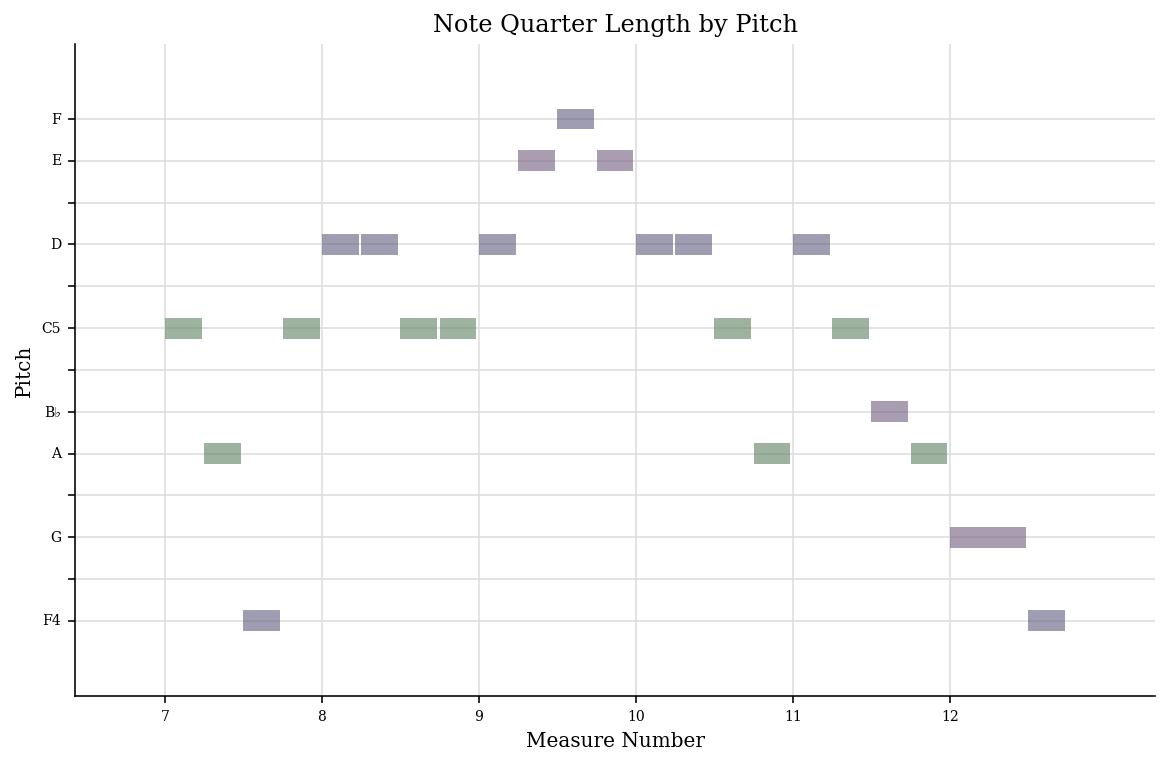

In [171]:
s1.parts[1].measures(7, 12).plot()

<music21.graph.plot.HorizontalBarPitchSpaceOffset for <music21.stream.Part Soprano>>

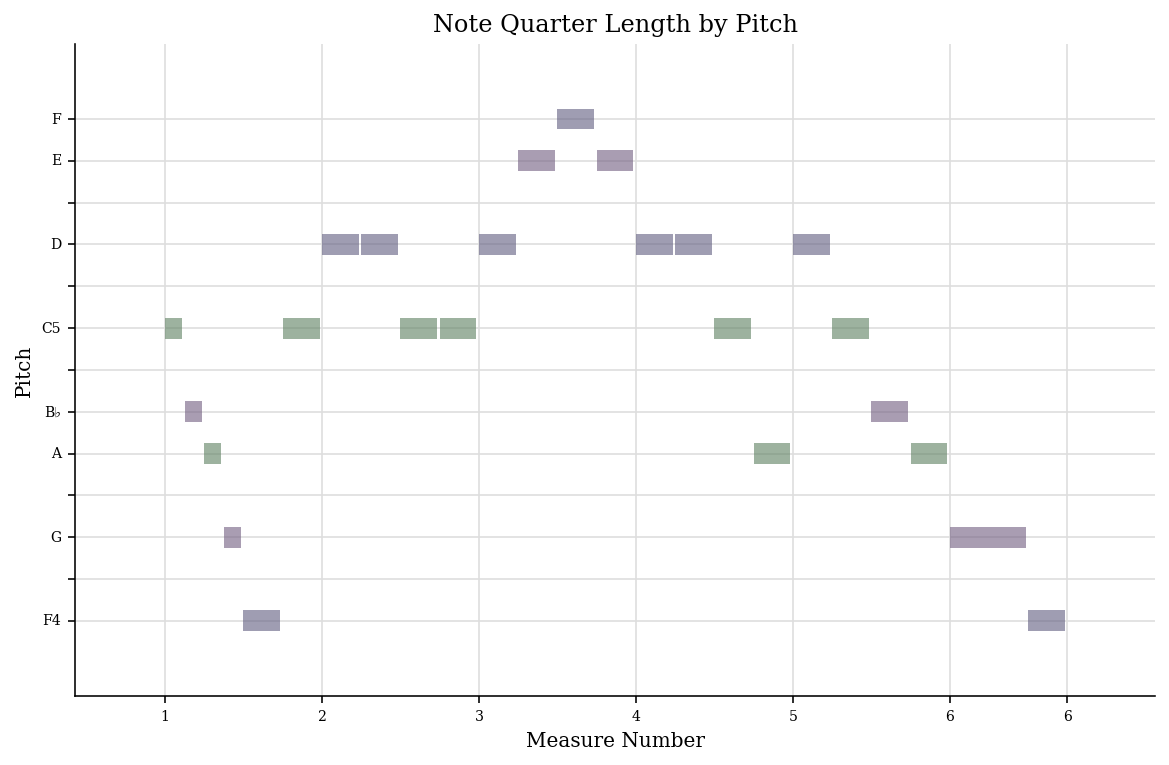

In [170]:
s2.parts[1].measures(1, 6).plot()

In [159]:
name1 = df.loc[df['note_part_id'] == first_keys[0]]
name2 = df.loc[df['note_part_id'] == first_keys[2]]
name1

,note_id,note_part_id,sheet_name,partName,sharps,bpm,key,time_signature,bpm (quarter note),clef,measures
3,3,3_2,bwv1.6.mxl,Soprano,-1,None,F major,4/4,None,treble,"[(0, 65, 1.0, 0.0), (1, 72, 1.0, 0.0), (1, 69,..."


In [160]:
name2

,note_id,note_part_id,sheet_name,partName,sharps,bpm,key,time_signature,bpm (quarter note),clef,measures
297,69,69_2,bwv172.6.mxl,Soprano,-1,None,A minor / F major,4/4,None,treble,"[(0, 65, 1.0, 0.0), (1, 72, 0.5, 0.0), (1, 70,..."


In [113]:
print(df.loc[df['sheet_name'] == 'bwv1.6.mxl'])   
print(df.loc[df['sheet_name'] == 'bwv172.6.mxl']['measures'][5:5+20])

   note_id  sheet_name partName  sharps   bpm      key time_signature  \
2        3  bwv1.6.mxl   Horn 2      -1  None  F major            4/4   
3        3  bwv1.6.mxl  Soprano      -1  None  F major            4/4   
4        3  bwv1.6.mxl     Alto      -1  None  F major            4/4   
5        3  bwv1.6.mxl    Tenor      -1  None  F major            4/4   
6        3  bwv1.6.mxl     Bass      -1  None  F major            4/4   

  bpm (quarter note)       clef  \
2               None     treble   
3               None     treble   
4               None     treble   
5               None  treble8vb   
6               None       bass   

                                            measures  
2  [(0, 65, 1.0, 0.0), (1, 67, 0.5, 0.0), (1, 60,...  
3  [(0, 65, 1.0, 0.0), (1, 72, 1.0, 0.0), (1, 69,...  
4  [(0, 60, 1.0, 0.0), (1, 60, 1.0, 0.0), (1, 60,...  
5  [(0, 57, 1.0, 0.0), (1, 55, 1.0, 0.0), (1, 57,...  
6  [(0, 53, 1.0, 0.0), (1, 52, 1.0, 0.0), (1, 53,...  
Series([], Name: mea

### Add Bach corpus elements to Excel file for further analysis

In [ ]:
df.to_csv('bach_notes.csv')

In [333]:
s = corpus.parse('bach/bwv277.mxl')
s.show('midi')

# Generating harmony to melody (not worth a try)

In [ ]:
harmony_chords = {
    1: ['A', 'C', 'E'],
    2: ['B', 'D', 'F#'],
    3: ['C', 'E', 'G#'],
    4: ['D', 'F#', 'A'],
    5: ['E', 'G#', 'B'],
    6: ['F', 'A', 'C'],
    7: ['G', 'B', 'D']
}

measure= []
for i in test_lst:
    if i[0] == 9:
        measure.append(i[1:2][0])


print(measure)
print(harmony_chords[2])

for elem in harmony_chords:
    print(str(elem) + ': ' + str(jaccard_distance(measure,harmony_chords[elem])) + ', ' + str(cosine_similarity_ngrams(measure,harmony_chords[elem])))
    
    
'''
1 = 1 kindel
2 = 6 kindel
3 = 4
4 = 5
'''